<a href="https://colab.research.google.com/github/VikramO/Roswell-Park-s-DBBR-Cancer-Patient-Survival-Prediction/blob/main/Roswell_Park's_DBBR_Cancer_Patient_Survival_Prediction_Team_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Roswell Park's DBBR Cancer Patient Survival Prediction

Team Members: Vikram, Matthew, and Mira

Link to AIM Datathon: https://www.kaggle.com/c/aimdatathon2020/leaderboard <br>
Link to Google Collab Notebooks: 
Patient Survival: https://colab.research.google.com/drive/1q05LU9_PN0izalQToJjcnErrsL3kc4Ji?usp=sharing
Stage Progression: https://colab.research.google.com/drive/1Un_WAmI-dcFe0WXgzBgwtBaNMMdDyJEv?usp=sharing

## Contents

* Problem
* Solution
* ML Pipeline
* Data Management
* Study Design
* Exploratory Data Analysis
* Validation Strategies
* Model Training, Testing, and Tuning
* Results,Model Performance,Interpretability
* Solution Video
* Acknowledgments



## Problem

There are many factors that impact cancer patient survival. These include gender, date of birth, enthicity as well as familial history, primiary site, cancer stage and grading among others. Our goal is to aid physicians in their decision making process by developing a machine learning model to assess the likelihood of survival based on these factors.





## Solution
- A clinical model based on the industry standard XGBoost algorithm was created to help physicians assess patients' risk by incorporating the data from Roswell Park Cancer Center. 



## ML-Pipeline


![image](https://user-images.githubusercontent.com/42708529/104794121-a5d53100-5773-11eb-8bb9-e901b48b661e.png)
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Management

 Set the appropriate directory.

In [ ]:
%cd /content/drive/My Drive/aimdatathon2020

/content/drive/My Drive/aimdatathon2020


The 17 tables available in the Roswell Park Data Repository were merged together to create a master data.The aggregation was performed by merging all of the available tables on the qbarcode column as a unique patient identifier.

In [ ]:
# import required dependencies 
import pandas as pd
import os

# load train and test data 
train = pd.read_csv('Tumor Information_train.csv')
test = pd.read_csv('Tumor Information_test.csv')

# Set all the column names in test and train data to lower case 
train.columns = map(str.lower, train.columns)
test.columns = map(str.lower, test.columns)

# Put all the files in the set directory into a list data structure with each file name as an element in the list
file_list = os.listdir()

# Remove the train and test files from the list as they're already defined
file_list.remove('Tumor Information_train.csv')
file_list.remove('Tumor Information_test.csv')

# Remove the questionnaire file from the list because it provides little information
file_list.remove('DBBR Questionnaire Data Dictionary.csv')

# View file_list to see the 17 files we have to work with
print(file_list)

# Left merge all the files in the list to the train and test sets on the qbarcode column
for data in file_list:
  train = train.merge(pd.read_csv(data).rename(columns=str.lower), on='qbarcode', how='left')
  test = test.merge(pd.read_csv(data).rename(columns=str.lower), on='qbarcode', how='left')

# Concatenate the train and test sets to create the master dataset
all_data = pd.concat([train, test])

['Beverages.csv', 'Current Lifestyle.csv', 'Family History.csv', 'Exercise.csv', 'Food Habits.csv', 'MedicationUseHistory.csv', 'Lifetime use of Supplements.csv', 'Nutrient Calc.csv', 'Herbals.csv', 'Foods.csv', 'Smoking History.csv', 'MedicalHistory.csv', 'Multivitamins.csv', 'Vitamins Minerals.csv', 'WomensHealth.csv', 'Background and Helpful Info.csv']


In [ ]:
test.head()

,qbarcode,primarysite,histology,grade,seersummstage2000,milk,milksv,soymlk,soymlksv,ricmlk,ricmlksv,latte,lattesv,coffee,coffeesv,cofcrm,cofcrmsv,tomjc,tomjcsv,orngjc,orngjcsv,jce100,jce100sv,cranjc,cranjcsv,fortjc,fortjcsv,dsoda,dsodasv,rsoda,rsodasv,slmfst,slmfstsv,water,watersv,beer,beersv,winred,winredsv,winwht,...,hrtyrs,hrtnow,menopause,sex,dobyear,age,country,ethn,ethn1,ethn2,ethn3,ethn4,ethn5,ethno,ethnoth,ethndk,race1,race2,race3,race4,race5,raceo,racedk,raceoth,litho1,educ,marital,instyp1,instyp2,instyp3,instyp4,instypno,instypo,instypdk,insuroth,hhinc,numsuprt,litho2,educ2,multiracial
0,856,"Breast, overlapping lesion",Infiltrating duct mixed w/ other types of carc...,"Grade I: Well differentiated, differentiated, NOS",1,1,1,99,2,0,2,1,1,7,1,0,2,2,1,3,1,1,1,2,1,0,2,2,1,0,2,0,2,8,2,8,1,4,1,1,...,4,99,99,2,1941,63,UNITED STATES OF AMERICA,0,66,66,66,66,66,66,NaN,66,1,0,0,0,0,0,0,NaN,3210,99,1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,5,2,3210,99,0
1,1759,Prostate gland,"Adenocarcinoma, NOS","Grade II: Mod diff, mod well diff, intermediat...",1,0,2,0,2,0,2,0,2,5,2,0,2,1,2,5,2,0,2,0,2,0,2,0,2,4,2,0,2,0,2,1,2,3,2,2,...,66,66,66,1,1931,74,UNITED STATES OF AMERICA,0,66,66,66,66,66,66,NaN,66,1,0,0,0,0,0,0,NaN,203023,5,1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,4,2,203023,3,0
2,2275,"Breast, lower-inner quadrant","Infiltrating duct carcinoma, NOS","Grade II: Mod diff, mod well diff, intermediat...",1,4,2,0,2,0,2,3,2,7,2,1,2,1,2,7,3,4,2,3,2,0,2,0,2,1,2,1,2,7,2,1,2,2,2,1,...,4,0,1,2,1946,59,UNITED STATES OF AMERICA,0,66,66,66,66,66,66,NaN,66,1,0,0,0,0,0,0,NaN,4713,5,2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,6,2,4713,3,0
3,1407,"Breast, upper-outer quadrant","Infiltrating duct carcinoma, NOS","Grade III: Poorly differentiated, dedifferenti...",1,4,2,0,2,0,2,1,2,0,2,4,2,1,2,2,2,4,2,2,2,1,2,1,2,1,2,1,2,4,2,4,2,1,2,1,...,66,66,0,2,1960,45,UNITED STATES OF AMERICA,0,66,66,66,66,66,66,NaN,66,1,0,0,0,0,0,0,NaN,1556,2,5,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2,3,1556,2,0
4,1996,"Bladder, overlapping lesion",Papillary transitional cell carcinoma,"Grade III: Poorly differentiated, dedifferenti...",1,0,2,0,2,0,2,0,2,9,2,9,2,1,2,2,2,99,2,5,2,0,2,3,2,0,2,0,2,7,2,2,2,0,2,0,...,66,66,66,1,1935,70,UNITED STATES OF AMERICA,0,66,66,66,66,66,66,NaN,66,1,0,0,0,0,0,0,NaN,203550,2,3,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,2,1,203550,2,0


In [ ]:
# View the first five entries of the master dataset
all_data.head()

,qbarcode,primarysite,histology,grade,seersummstage2000,patientstatus,milk,milksv,soymlk,soymlksv,ricmlk,ricmlksv,latte,lattesv,coffee,coffeesv,cofcrm,cofcrmsv,tomjc,tomjcsv,orngjc,orngjcsv,jce100,jce100sv,cranjc,cranjcsv,fortjc,fortjcsv,dsoda,dsodasv,rsoda,rsodasv,slmfst,slmfstsv,water,watersv,beer,beersv,winred,winredsv,...,hrtyrs,hrtnow,menopause,sex,dobyear,age,country,ethn,ethn1,ethn2,ethn3,ethn4,ethn5,ethno,ethnoth,ethndk,race1,race2,race3,race4,race5,raceo,racedk,raceoth,litho1,educ,marital,instyp1,instyp2,instyp3,instyp4,instypno,instypo,instypdk,insuroth,hhinc,numsuprt,litho2,educ2,multiracial
0,1454,Prostate gland,"Adenocarcinoma, NOS","Grade III: Poorly differentiated, dedifferenti...",2,1.0,6,3,0,2,0,2,3,1,7,3,0,2,1,1,1,1,0,2,1,3,0,2,2,1,0,2,0,2,9,3,3,3,1,3,...,66,66,66,1,1952,52,UNITED STATES OF AMERICA,0,66,66,66,66,66,66,NaN,66,1,0,0,0,0,0,0,NaN,203928,3,5,NaN,NaN,1.0,NaN,NaN,88.0,NaN,I PAY 50 PERCENT,6,5,203928,3,0
1,21967,"Lung, upper lobe",Mucinous adenocarcinoma,"Grade II: Mod diff, mod well diff, intermediat...",1,1.0,0,2,0,2,0,2,1,2,7,3,7,3,0,2,2,2,0,2,0,2,0,2,0,2,1,2,0,2,8,3,0,2,0,2,...,66,66,1,2,1957,57,UNITED STATES OF AMERICA,0,66,66,66,66,66,66,NaN,66,1,0,0,0,0,0,0,NaN,29844,3,5,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2,1,29844,3,0
2,1146,"Peritoneum, specified parts of",Serous surface papillary carcinoma,"Grade III: Poorly differentiated, dedifferenti...",2,0.0,4,2,0,2,0,2,3,2,0,2,7,2,0,2,5,2,3,2,2,2,2,2,0,2,3,2,0,2,7,1,0,2,1,2,...,66,66,1,2,1946,58,UNITED STATES OF AMERICA,0,66,66,66,66,66,66,NaN,66,1,0,0,0,0,0,0,NaN,2747,5,1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,5,5,2747,3,0
3,2815,Prostate gland,"Adenocarcinoma, NOS","Grade III: Poorly differentiated, dedifferenti...",1,1.0,0,2,0,2,0,2,0,2,6,1,6,1,0,2,0,2,0,2,0,2,0,2,99,2,0,2,6,2,6,2,2,2,7,2,...,66,66,66,1,1947,58,UNITED STATES OF AMERICA,0,66,66,66,66,66,66,NaN,66,1,0,0,0,0,0,0,NaN,200464,3,1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,4,2,200464,3,0
4,214,"Breast, overlapping lesion","Infiltrating duct carcinoma, NOS","Grade II: Mod diff, mod well diff, intermediat...",3,1.0,1,1,0,2,0,2,1,1,8,1,8,1,1,1,0,2,0,2,2,1,1,1,0,2,0,2,0,2,7,1,2,1,2,1,...,66,66,0,2,1958,45,UNITED STATES OF AMERICA,0,66,66,66,66,66,66,NaN,66,1,0,0,0,0,0,0,NaN,1818,4,5,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,6,3,1818,3,0


In [ ]:
print(all_data['age'])

0      52
1      57
2      58
3      58
4      45
       ..
395    73
396    53
397    59
398    68
399    52
Name: age, Length: 2000, dtype: int64


##Data Pre-processing

We process the data by encoding categorical columns and filling NaN values with the mode of the feature. Notice how we do not normalize the data or check for multicollinearity. This will make sense very shortly. We also notice that there is mild class imbalance between the two categories.  

In [ ]:
# Import preprocessing utilities from scikit-learn
from sklearn import preprocessing

# Create a list of all columns that aren't patientstatus or qbarcode
cols = [col for col in all_data.columns if col not in ['patientstatus', 'qbarcode']]

types = all_data.dtypes
cat_columns = [t[0] for t in types.iteritems() if ((t[1] not in ['int64', 'float64']))]

# Encode the non-numerical data
lbl = preprocessing.LabelEncoder()
for col in cat_columns:
    all_data[col] = lbl.fit_transform(all_data[col].astype(str))

# Impute missing data with the mode
all_data = all_data.fillna(all_data.mode().iloc[0])

# Seperate the processed data into test and train 
train_processed_data = all_data.iloc[:len(train)]
test_processed_data = all_data.iloc[len(train):]

# Print the dimensions of the train and test data 
print('Below are the shapes of our of our train and test sets:')
print('Train:', train_processed_data.shape)
print('Test:', test_processed_data.shape)

# Print the frequency of each class: survival versus non survival
print('The frequencies of each class:')
print(train['patientstatus'].value_counts())

Below are the shapes of our of our train and test sets:
Train: (1600, 1214)
Test: (400, 1214)
The frequencies of each class:
1    996
0    604
Name: patientstatus, dtype: int64


## Study Design

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([ 1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  3.,  0.,  3.,
         1.,  0.,  3.,  2.,  2.,  0.,  7.,  9.,  9.,  0.,  6., 12.,  0.,
        10., 10., 17.,  0., 15., 21., 34.,  0., 23., 27., 28.,  0., 39.,
        39.,  0., 43., 39., 41.,  0., 51., 51., 51.,  0., 58., 64.,  0.,
        75., 69., 59.,  0., 61., 63., 63.,  0., 54., 66.,  0., 71., 57.,
        56.,  0., 58., 38., 40.,  0., 54., 42., 39.,  0., 42., 36.,  0.,
        34., 34., 30.,  0., 20., 27., 16.,  0., 19., 14.,  0., 11.,  6.,
         6.,  0.,  7.,  5.,  0.,  0.,  5.,  0.,  1.]),
 array([20.  , 20.73, 21.46, 22.19, 22.92, 23.65, 24.38, 25.11, 25.84,
        26.57, 27.3 , 28.03, 28.76, 29.49, 30.22, 30.95, 31.68, 32.41,
        33.14, 33.87, 34.6 , 35.33, 36.06, 36.79, 37.52, 38.25, 38.98,
        39.71, 40.44, 41.17, 41.9 , 42.63, 43.36, 44.09, 44.82, 45.55,
        46.28, 47.01, 47.74, 48.47, 49.2 , 49.93, 50.66, 51.39, 52.12,
        52.85, 53.58, 54.31, 55.04, 55.77, 56.5 , 57.23, 57.96, 58.69,
        

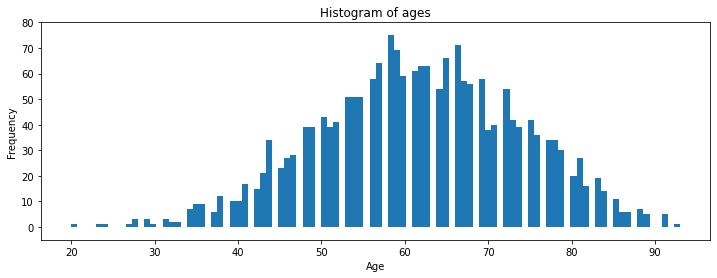

In [ ]:
%pylab inline

#Create histograms of patients' identifying information
#Such as age, gender, race, cancer types

n_bins=100

var_1 = all_data['age'].values
var_2 = lbl.fit_transform(all_data['primarysite'])


figsize(12,4)
ylim([-5,80])

# Add title and axis names 
plt.title('Histogram of ages') 
plt.xlabel('Age') 
plt.ylabel('Frequency')

pyplot.hist(var_1, bins=n_bins)

(array([  7.,   3.,   2.,   5.,  20.,   1.,   4.,  24.,   3.,   2.,   2.,
         40.,  22.,   1.,  67.,  53., 186., 101., 302.,   5.,  12.,   1.,
         32.,  34.,   6.,   4.,   4.,  13.,   1.,   1.,   8.,   1.,  74.,
          1.,  23.,   1.,   1.,   1.,   3.,   2.,   1.,   2.,   6.,   1.,
          2.,   2.,   2., 121.,   1.,   1.,  11.,   1.,   2.,  57.,   1.,
         79.,   1.,   6.,   1.,  19.,   1.,  14.,   1.,   2.,   2.,   2.,
          1., 371.,   1.,  32.,  61.,   2.,   4.,  35.,   1.,   1.,   2.,
          4.,   2.,   2.,  18.,   6.,   1.,   4.,   2.,   2.,   3.,   2.,
          4.,   1.,   1.,   1.,   3.,   1.,   1.,   3.,   7.,   1.,   1.,
          7.]),
 array([  0.  ,   1.26,   2.52,   3.78,   5.04,   6.3 ,   7.56,   8.82,
         10.08,  11.34,  12.6 ,  13.86,  15.12,  16.38,  17.64,  18.9 ,
         20.16,  21.42,  22.68,  23.94,  25.2 ,  26.46,  27.72,  28.98,
         30.24,  31.5 ,  32.76,  34.02,  35.28,  36.54,  37.8 ,  39.06,
         40.32,  41.58,  42.84

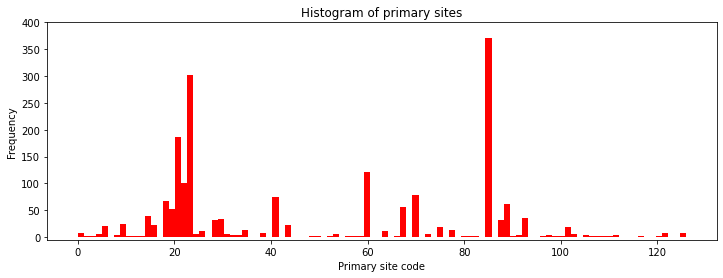

In [ ]:
ylim([-5,400])

# Add title and axis names 
plt.title('Histogram of primary sites') 
plt.xlabel('Primary site code') 
plt.ylabel('Frequency')

pyplot.hist(var_2, bins=n_bins, color='red')

In [ ]:
all_data['primarysite_encoded'] = var_2
all_data['primarysite_encoded'].value_counts()

85    371
23    302
21    186
60    121
22    101
     ... 
71      1
72      1
74      1
76      1
63      1
Name: primarysite_encoded, Length: 127, dtype: int64

In [ ]:
#compute summary statistics of data
all_data.describe()

,qbarcode,primarysite,histology,grade,seersummstage2000,patientstatus,milk,milksv,soymlk,soymlksv,ricmlk,ricmlksv,latte,lattesv,coffee,coffeesv,cofcrm,cofcrmsv,tomjc,tomjcsv,orngjc,orngjcsv,jce100,jce100sv,cranjc,cranjcsv,fortjc,fortjcsv,dsoda,dsodasv,rsoda,rsodasv,slmfst,slmfstsv,water,watersv,beer,beersv,winred,winredsv,...,hrtnow,menopause,sex,dobyear,age,country,ethn,ethn1,ethn2,ethn3,ethn4,ethn5,ethno,ethnoth,ethndk,race1,race2,race3,race4,race5,raceo,racedk,raceoth,litho1,educ,marital,instyp1,instyp2,instyp3,instyp4,instypno,instypo,instypdk,insuroth,hhinc,numsuprt,litho2,educ2,multiracial,primarysite_encoded
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.00000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,6074.804500,49.883000,42.657500,1.264500,1.608000,0.69800,5.262500,1.94700,3.7190,1.975000,3.943500,1.994500,4.225000,1.907000,7.338000,1.986500,6.365500,1.905000,4.435500,1.908000,5.639500,1.898500,5.765500,1.91700,4.204500,1.894000,3.704500,1.955500,5.151500,1.935000,4.61600,1.877000,3.621000,1.977500,9.507500,2.133500,4.956000,1.929500,4.149000,1.938000,...,54.346000,26.742000,1.607500,1945.118500,61.656000,29.979000,1.043500,65.722000,65.789000,65.786500,65.671500,65.704000,66.055000,6.983000,65.642500,1.334500,0.441000,0.406500,0.399500,0.397500,0.742500,0.434500,4.991000,86736.688000,4.798000,3.644000,1.0,1.0,1.0,1.0,0.0,88.0,77.0,89.13150,7.575500,58.606000,86738.240000,4.346000,0.353500,49.883000
std,6395.787317,30.842518,32.914235,0.756853,1.029498,0.45924,14.455382,0.52757,18.3066,0.185451,19.284897,0.080455,17.152681,0.407963,14.649063,0.541724,16.189316,0.509023,17.404232,0.434316,15.854123,0.545295,19.253541,0.48086,16.039492,0.455925,17.507497,0.290796,17.254287,0.394782,16.86196,0.413469,17.399417,0.207401,15.581699,0.613894,18.287134,0.386787,16.773117,0.404027,...,25.767601,32.167652,0.488429,11.588037,12.029132,4.890656,9.997529,7.463683,7.158918,7.181692,7.579004,7.439628,6.958533,0.282402,7.498387,6.195224,6.250924,6.250503,6.250395,6.250362,8.284595,6.480795,0.178704,97169.011063,12.987784,12.161259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.33189,18.107989,230.188506,97176.579931,13.013914,5.848302,30.842518
min,100.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.00000,0.0000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,1912.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,297.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,0.0,88.0,77.0,0.00000,1.000000,0.000000,297.000000,1.000000,0.000000,0.000000
25%,1906.000000,22.000000,7.000000,1.000000,1.000000,0.00000,1.000000,2.00000,0.0000,2.000000,0.000000,2.000000,0.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000,2.000000,1.000000,2.000000,0.000000,2.00000,0.000000,2.000000,0.000000,2.000000,0.000000,2.000000,0.00000,2.000000,0.000000,2.000

In [ ]:
# View the first five entries of the train_processed_data
train_processed_data.head()

,qbarcode,primarysite,histology,grade,seersummstage2000,patientstatus,milk,milksv,soymlk,soymlksv,ricmlk,ricmlksv,latte,lattesv,coffee,coffeesv,cofcrm,cofcrmsv,tomjc,tomjcsv,orngjc,orngjcsv,jce100,jce100sv,cranjc,cranjcsv,fortjc,fortjcsv,dsoda,dsodasv,rsoda,rsodasv,slmfst,slmfstsv,water,watersv,beer,beersv,winred,winredsv,...,hrtyrs,hrtnow,menopause,sex,dobyear,age,country,ethn,ethn1,ethn2,ethn3,ethn4,ethn5,ethno,ethnoth,ethndk,race1,race2,race3,race4,race5,raceo,racedk,raceoth,litho1,educ,marital,instyp1,instyp2,instyp3,instyp4,instypno,instypo,instypdk,insuroth,hhinc,numsuprt,litho2,educ2,multiracial
0,1454,85,7,2,2,1.0,6,3,0,2,0,2,3,1,7,3,0,2,1,1,1,1,0,2,1,3,0,2,2,1,0,2,0,2,9,3,3,3,1,3,...,66,66,66,1,1952,52,31,0,66,66,66,66,66,66,7,66,1,0,0,0,0,0,0,5,203928,3,5,1.0,1.0,1.0,1.0,0.0,88.0,77.0,40,6,5,203928,3,0
1,21967,70,76,1,1,1.0,0,2,0,2,0,2,1,2,7,3,7,3,0,2,2,2,0,2,0,2,0,2,0,2,1,2,0,2,8,3,0,2,0,2,...,66,66,1,2,1957,57,31,0,66,66,66,66,66,66,7,66,1,0,0,0,0,0,0,5,29844,3,5,1.0,1.0,1.0,1.0,0.0,88.0,77.0,94,2,1,29844,3,0
2,1146,81,103,2,2,0.0,4,2,0,2,0,2,3,2,0,2,7,2,0,2,5,2,3,2,2,2,2,2,0,2,3,2,0,2,7,1,0,2,1,2,...,66,66,1,2,1946,58,31,0,66,66,66,66,66,66,7,66,1,0,0,0,0,0,0,5,2747,5,1,1.0,1.0,1.0,1.0,0.0,88.0,77.0,94,5,5,2747,3,0
3,2815,85,7,2,1,1.0,0,2,0,2,0,2,0,2,6,1,6,1,0,2,0,2,0,2,0,2,0,2,99,2,0,2,6,2,6,2,2,2,7,2,...,66,66,66,1,1947,58,31,0,66,66,66,66,66,66,7,66,1,0,0,0,0,0,0,5,200464,3,1,1.0,1.0,1.0,1.0,0.0,88.0,77.0,94,4,2,200464,3,0
4,214,21,49,1,3,1.0,1,1,0,2,0,2,1,1,8,1,8,1,1,1,0,2,0,2,2,1,1,1,0,2,0,2,0,2,7,1,2,1,2,1,...,66,66,0,2,1958,45,31,0,66,66,66,66,66,66,7,66,1,0,0,0,0,0,0,5,1818,4,5,1.0,1.0,1.0,1.0,0.0,88.0,77.0,94,6,3,1818,3,0


In [ ]:
# View the first five entries of the test_processed_data
test_processed_data.head()

,qbarcode,primarysite,histology,grade,seersummstage2000,patientstatus,milk,milksv,soymlk,soymlksv,ricmlk,ricmlksv,latte,lattesv,coffee,coffeesv,cofcrm,cofcrmsv,tomjc,tomjcsv,orngjc,orngjcsv,jce100,jce100sv,cranjc,cranjcsv,fortjc,fortjcsv,dsoda,dsodasv,rsoda,rsodasv,slmfst,slmfstsv,water,watersv,beer,beersv,winred,winredsv,...,hrtyrs,hrtnow,menopause,sex,dobyear,age,country,ethn,ethn1,ethn2,ethn3,ethn4,ethn5,ethno,ethnoth,ethndk,race1,race2,race3,race4,race5,raceo,racedk,raceoth,litho1,educ,marital,instyp1,instyp2,instyp3,instyp4,instypno,instypo,instypdk,insuroth,hhinc,numsuprt,litho2,educ2,multiracial
0,856,21,50,0,1,1.0,1,1,99,2,0,2,1,1,7,1,0,2,2,1,3,1,1,1,2,1,0,2,2,1,0,2,0,2,8,2,8,1,4,1,...,4,99,99,2,1941,63,31,0,66,66,66,66,66,66,7,66,1,0,0,0,0,0,0,5,3210,99,1,1.0,1.0,1.0,1.0,0.0,88.0,77.0,94,5,2,3210,99,0
1,1759,85,7,1,1,1.0,0,2,0,2,0,2,0,2,5,2,0,2,1,2,5,2,0,2,0,2,0,2,0,2,4,2,0,2,0,2,1,2,3,2,...,66,66,66,1,1931,74,31,0,66,66,66,66,66,66,7,66,1,0,0,0,0,0,0,5,203023,5,1,1.0,1.0,1.0,1.0,0.0,88.0,77.0,94,4,2,203023,3,0
2,2275,18,49,1,1,1.0,4,2,0,2,0,2,3,2,7,2,1,2,1,2,7,3,4,2,3,2,0,2,0,2,1,2,1,2,7,2,1,2,2,2,...,4,0,1,2,1946,59,31,0,66,66,66,66,66,66,7,66,1,0,0,0,0,0,0,5,4713,5,2,1.0,1.0,1.0,1.0,0.0,88.0,77.0,94,6,2,4713,3,0
3,1407,23,49,2,1,1.0,4,2,0,2,0,2,1,2,0,2,4,2,1,2,2,2,4,2,2,2,1,2,1,2,1,2,1,2,4,2,4,2,1,2,...,66,66,0,2,1960,45,31,0,66,66,66,66,66,66,7,66,1,0,0,0,0,0,0,5,1556,2,5,1.0,1.0,1.0,1.0,0.0,88.0,77.0,94,2,3,1556,2,0
4,1996,10,89,2,1,1.0,0,2,0,2,0,2,0,2,9,2,9,2,1,2,2,2,99,2,5,2,0,2,3,2,0,2,0,2,7,2,2,2,0,2,...,66,66,66,1,1935,70,31,0,66,66,66,66,66,66,7,66,1,0,0,0,0,0,0,5,203550,2,3,1.0,1.0,1.0,1.0,0.0,88.0,77.0,94,2,1,203550,2,0


## Validation Strategies 


Import the necessary machine learning models. Since we have a classification task with structured data, XGBoost is a safe bet with proven performance in industry.

Decision trees do not require normalization of inputs, and since XGBoost is an ensemble of decision trees, this principle also applies here. XGBoost naturally deals with multicollinearity as well.

The labels in our test set are hidden to the model, so we have use a part of the training set as a validation set to assess our model's performance.

In [ ]:
# import required model and reporting dependencies 
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

# Create a list of all columns that aren't patientstatus or qbarcode
cols = [col for col in train_processed_data.columns if col not in ['patientstatus', 'qbarcode']]

# Turn data into numpy arrays 
train = train_processed_data[cols].values
labels = train_processed_data['patientstatus'].values

# Split the train data into traning and validation data (80/20 split)
x_train, x_val, y_train, y_val = train_test_split(train, labels, test_size=0.2, random_state=42)

## Model Training, Tuning, and Validation

We use the XGBoost (extreme gradient boosting) model. XGBoost is an ensemble method that uses many weaker decision trees to classify the data. Hyperparameters are set manually by the user. The values of the hyperparameters were obtained by repeatedly fitting the model until we reached an optimal performance.

We used accuracy and area under reciever operator characteristic curve values to get baseline numeric performance measures, and we then view the classification report to check for Type 1 and Type 2 error rates. 

In [ ]:
# Initailize the model and tune the parameters
bst = xgb.XGBClassifier(max_depth=2, n_estimators=100, learning_rate=0.1, objective='reg:logistic', gamma=0, colsample_bytree=0.3)

# fit the model 
bst.fit(x_train, y_train)
print("Model Training Accuracy:", bst.score(x_train, y_train)*100, "%")

Model Training Accuracy: 84.140625 %


## Results: Model Performance and Interpretability

In [ ]:
# Generate predictions 
y_hat = bst.predict(x_val)

# Print performance metrics 
print('Accuracy Score:', bst.score(x_val, y_val))
print('Area under ROC:', roc_auc_score(y_val, y_hat))

# Print the classification report to check the type 1 (false positive) and type 2 (false negative) error rates
print(classification_report(y_val, y_hat))


Accuracy Score: 0.75625
Area under ROC: 0.7146993697836825
              precision    recall  f1-score   support

         0.0       0.69      0.57      0.62       114
         1.0       0.78      0.86      0.82       206

    accuracy                           0.76       320
   macro avg       0.74      0.71      0.72       320
weighted avg       0.75      0.76      0.75       320



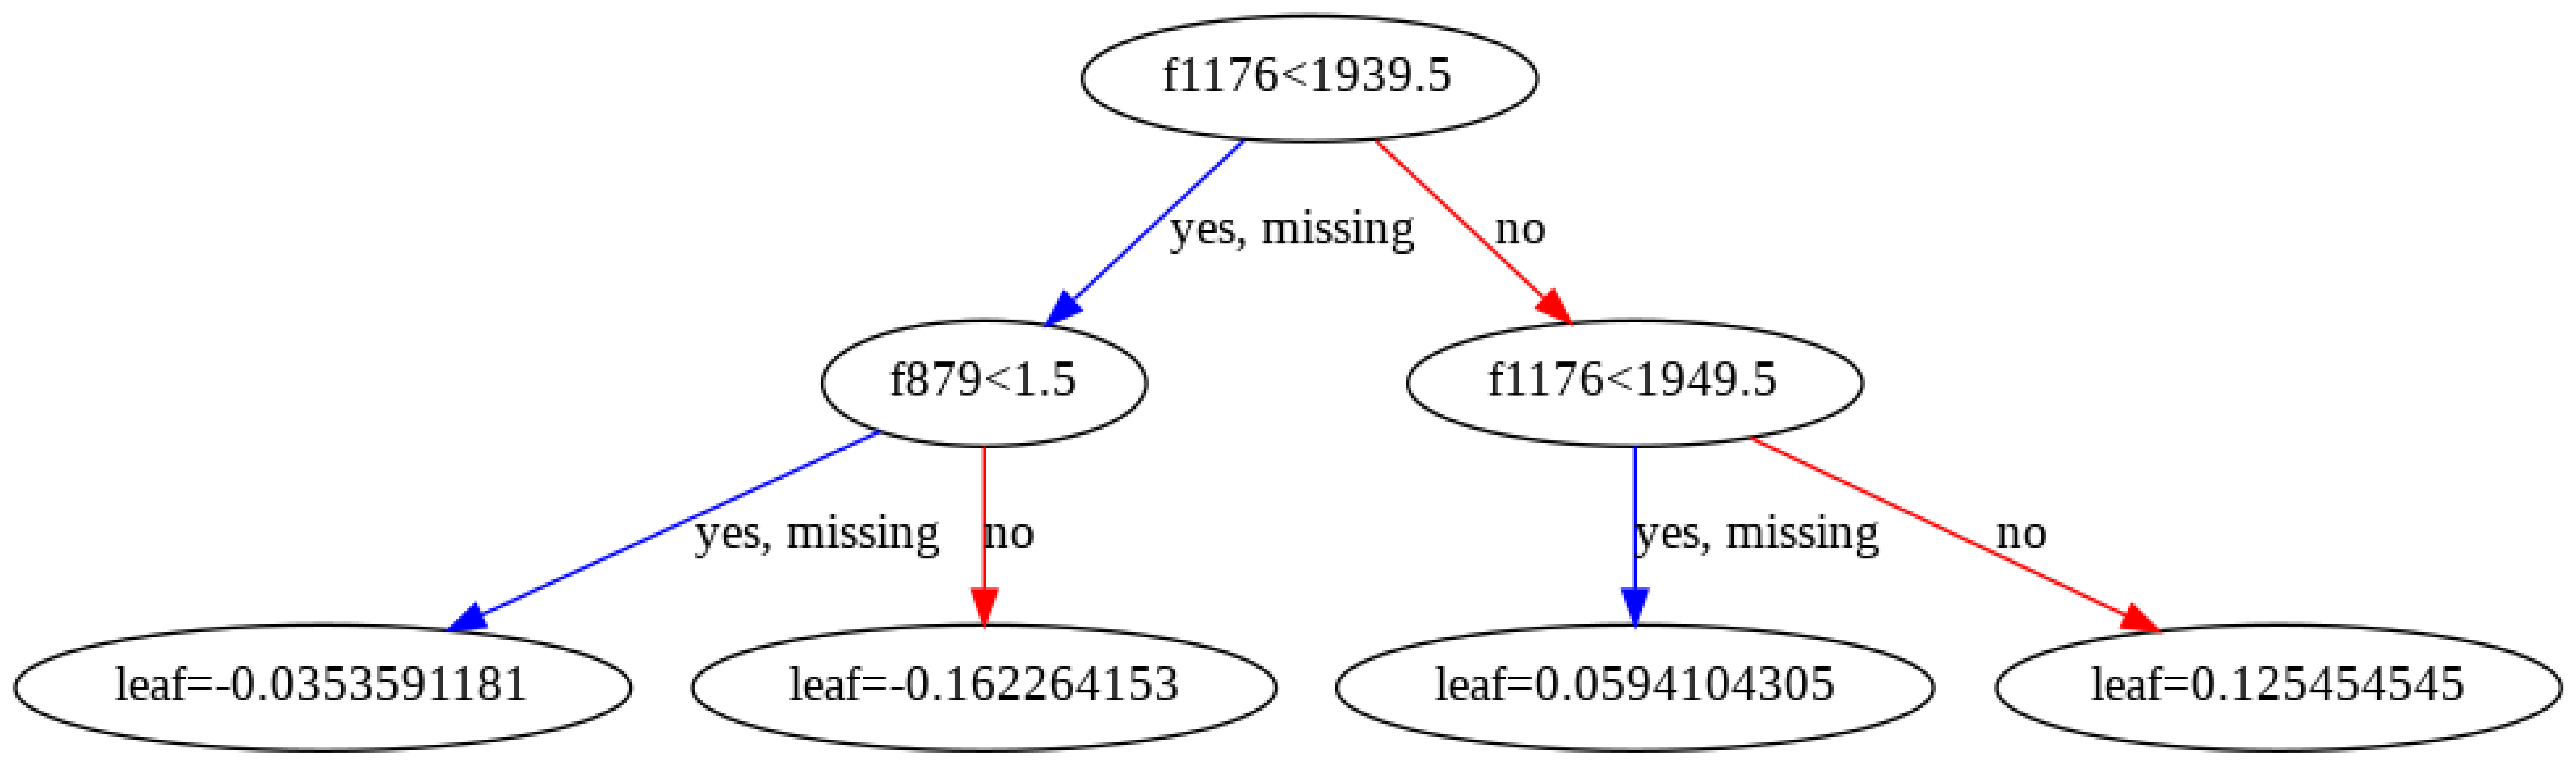

In [ ]:
from xgboost import plot_tree
plot_tree(bst)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
#fig.savefig('tree.png')

Plot the ROC curve.

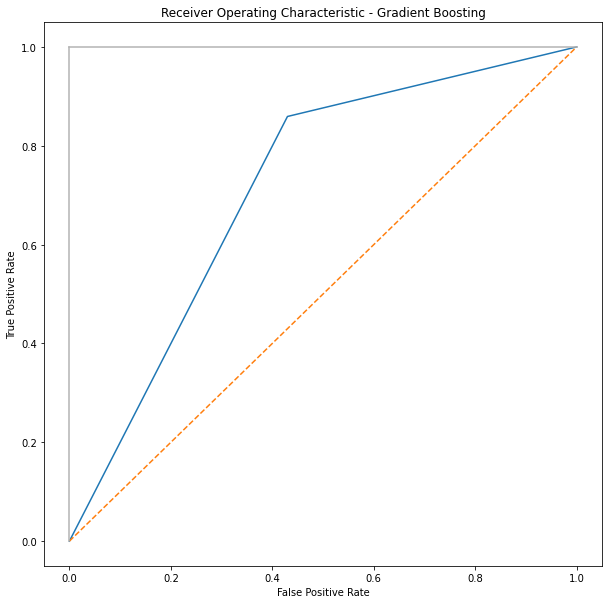

In [ ]:
# Get ROC curve metrics 
false_positive_rate, true_positive_rate, threshold = roc_curve(y_val, y_hat)

# Plot ROC curve
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Gradient Boosting')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Now we can make predictions on our unseen test data and view them patient-by-patient. Only the first 20 are shown.

In [ ]:
# Turn the unseen test data into a numpy array
test= test_processed_data[cols].values

# Generate predictions
predictions = bst.predict(test)

# Match patients with their prediction
out_df = pd.DataFrame(
        {"qbarcode": test_processed_data.qbarcode.values,
         "PatientStatus": predictions
        }
    )

# View the predictions of the first 20 patients
print(out_df.head(20))

    qbarcode  PatientStatus
0        856            1.0
1       1759            1.0
2       2275            1.0
3       1407            1.0
4       1996            0.0
5      10961            0.0
6        264            1.0
7      16155            0.0
8       5183            0.0
9       3052            1.0
10     12893            1.0
11      2873            1.0
12      5178            1.0
13      5835            1.0
14      4330            1.0
15      3707            1.0
16     13348            0.0
17     15620            1.0
18       360            1.0
19      4578            1.0


Create a submission file

In [ ]:
#out_df.to_csv('submission_aim.csv', index=False)

## Stage Proression Prediction Post Analysis

We applied the XGBoost model to the task of predicting tumor stage progression. For this task, we used the most prevalent cancer type in the dataset, which in this case happened to be prostate cancer.

In [ ]:
prog_cols = [col for col in all_data.columns if col not in ['grade', 'qbarcode']]

types = all_data.dtypes
cat_prog_columns = [t[0] for t in types.iteritems() if ((t[1] not in ['int64', 'float64']))]

print('Label encoding categorical columns:', cat_prog_columns)
for col in cat_prog_columns:
    all_data[col] = lbl.fit_transform(all_data[col].astype(str))

all_data = all_data.fillna(all_data.mode().iloc[0])

train_prog_processed_data = all_data.iloc[:len(train)]
test_prog_processed_data = all_data.iloc[len(train):]

'''
grade 3 encoding = 2
grade 2 encoding = 1
grade 1 encoding = 0
prostate encoding = 85
'''

print(all_data['primarysite'].value_counts())
prostate_data = all_data.loc[all_data['primarysite'] == 85]
prostate_data = prostate_data.loc[prostate_data['grade'] != 0]
prostate_data['grade'] = prostate_data['grade'] - 1
print(prostate_data['grade'].value_counts())
print(prostate_data.head())

prostate_cols = [col for col in prostate_data.columns if col not in ['grade', 'qbarcode']]

Label encoding categorical columns: []
85    371
23    302
21    186
60    121
22    101
     ... 
71      1
72      1
74      1
76      1
63      1
Name: primarysite, Length: 127, dtype: int64
1    223
0    147
Name: grade, dtype: int64
    qbarcode  primarysite  histology  ...  educ2  multiracial  primarysite_encoded
0       1454           85          7  ...      3            0                   85
3       2815           85          7  ...      3            0                   85
6       2706           85          7  ...      3            0                   85
10      5819           85          7  ...      2            0                   85
19     26291           85          7  ...      3            0                   85

[5 rows x 1215 columns]


In [ ]:
# Turn data into numpy arrays 
train_prog = prostate_data[prostate_cols].values
labels_prog = prostate_data['grade'].values

# Split the train data into traning and validation data (80/20 split)
x_prog_train, x_prog_val, y_prog_train, y_prog_val = train_test_split(train_prog, labels_prog, test_size=0.2, random_state=42)

In [ ]:
bst_prog = xgb.XGBClassifier(max_depth=2, n_estimators=100, learning_rate=0.1, objective='reg:logistic', gamma=0, colsample_bytree=0.3)

# fit the model 
bst_prog.fit(x_prog_train, y_prog_train)
print("Model Training Accuracy:", bst_prog.score(x_prog_train, y_prog_train)*100, "%")

Model Training Accuracy: 98.64864864864865 %


## Stage Progression Results

In [ ]:
y_prog_hat = bst_prog.predict(x_prog_val)

# Print performance metrics 
print('Accuracy Score:', bst_prog.score(x_prog_val, y_prog_val))
print('Area under ROC:', roc_auc_score(y_prog_val, y_prog_hat))

# Print the classification report to check the type 1 (false positive) and type 2 (false negative) error rates
print(classification_report(y_prog_val, y_prog_hat))

Accuracy Score: 0.5540540540540541
Area under ROC: 0.5266075388026608
              precision    recall  f1-score   support

           0       0.50      0.27      0.35        33
           1       0.57      0.78      0.66        41

    accuracy                           0.55        74
   macro avg       0.54      0.53      0.51        74
weighted avg       0.54      0.55      0.52        74



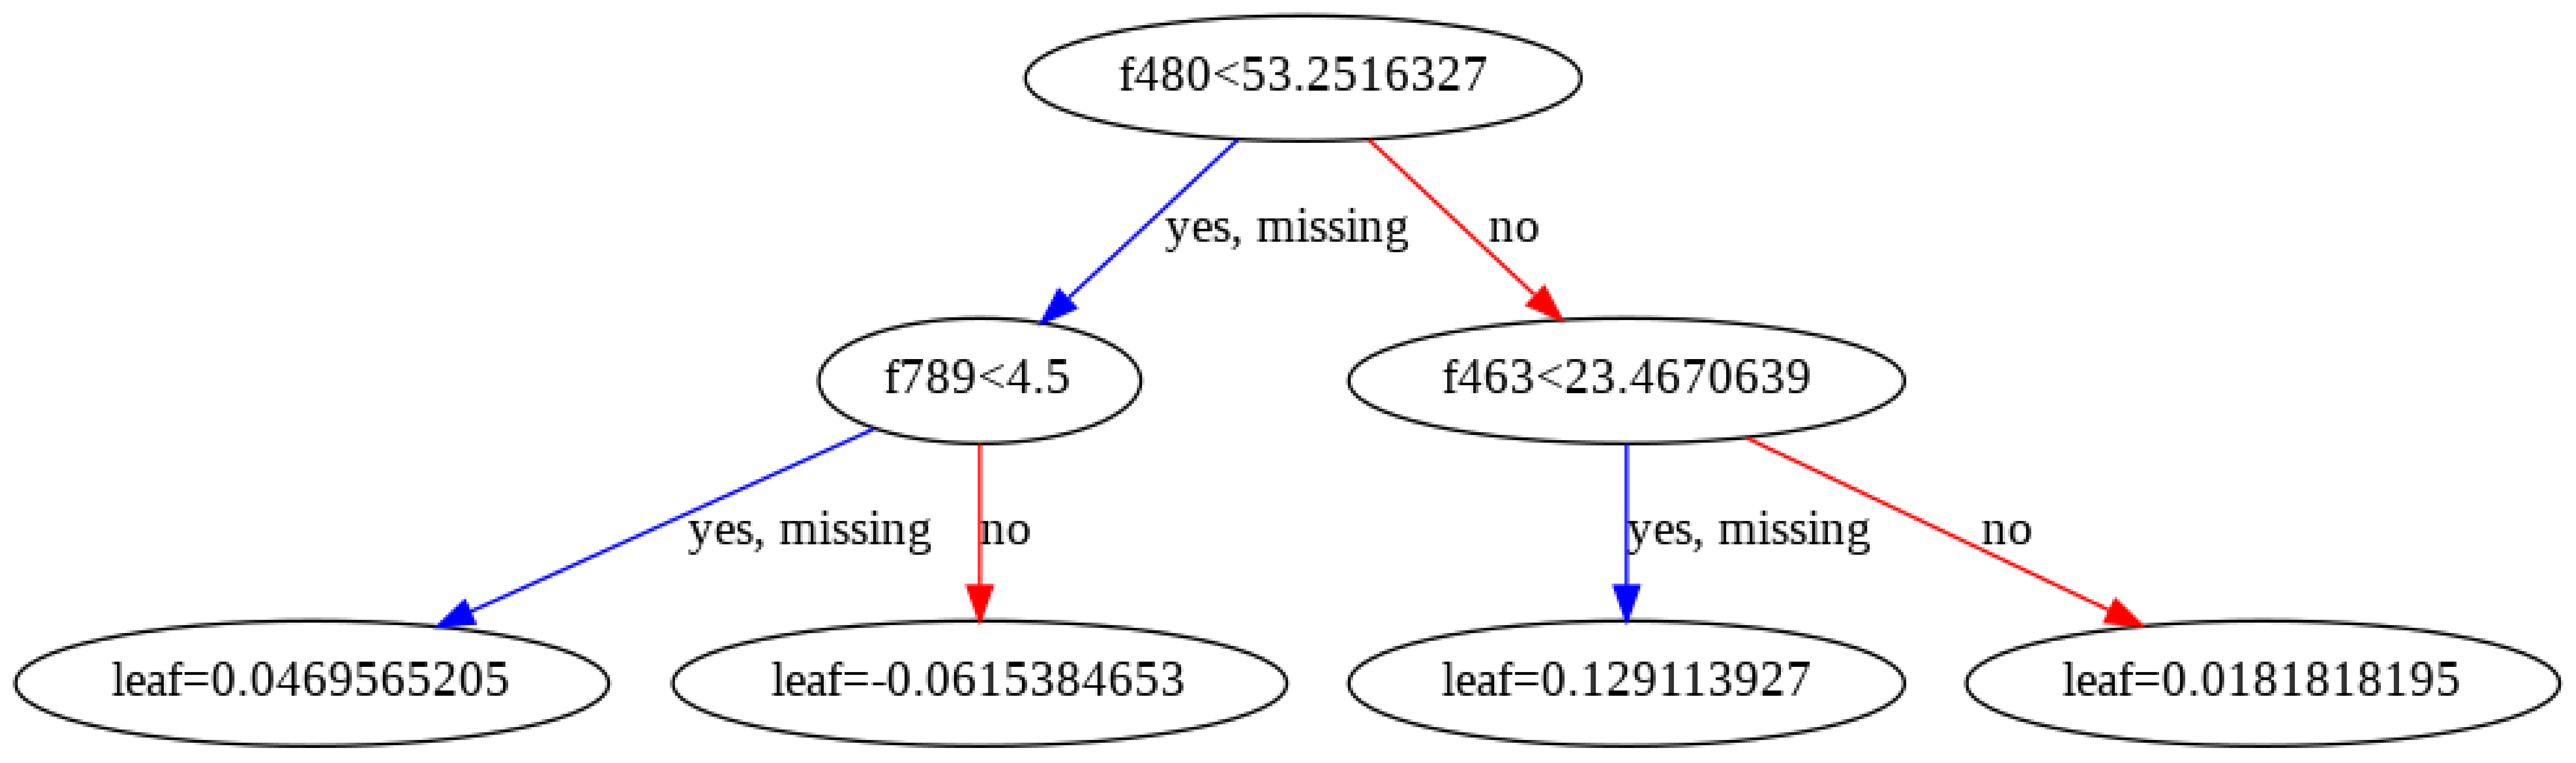

In [ ]:
#Plot decision tree
from xgboost import plot_tree
plot_tree(bst_prog)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)

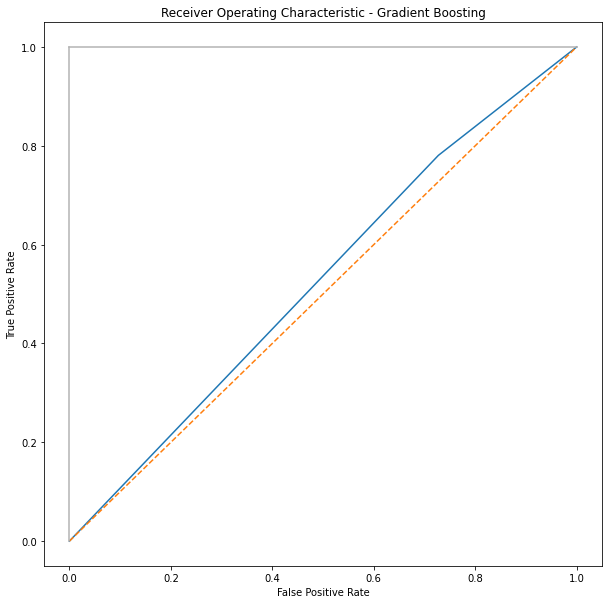

In [ ]:
# Get ROC curve metrics 
false_prog_positive_rate, true_prog_positive_rate, threshold = roc_curve(y_prog_val, y_prog_hat)

# Plot ROC curve
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Gradient Boosting')
plt.plot(false_prog_positive_rate, true_prog_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
all_data.head()

,qbarcode,primarysite,histology,seersummstage2000,patientstatus
0,1454,85,7,2,1.0
1,21967,70,76,1,1.0
2,1146,81,103,2,0.0
3,2815,85,7,1,1.0
4,214,21,49,3,1.0
